## Bayesian Statistics Made Simple

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2019 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import matplotlib.pyplot as plt

from empiricaldist import Pmf

### The World Cup problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome, we can answer the following questions:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance Croatia would win?

To answer these questions, we have to make some modeling assumptions:

1. Goal scoring can be well modeled by a Poisson process, so the distribution of goals scored by each team against the other is Poisson($\lambda$), where $\lambda$ is a goal-scoring rate, measured in goals per game.

2. For two random World Cup teams, the disrtribution of goal scoring rates is Gamma($\alpha$), where $\alpha$ is a parameter we can choose based on past results.

To determine $\alpha$, I used [data from previous World Cups](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/) to estimate that the average goal scoring rate is about 1.4 goals per game.

We can use `scipy.stats.gamma` to compute the PDF of the Gamma distribution.

In [2]:
from scipy.stats import gamma

α = 1.4
qs = np.linspace(0, 6)
ps = gamma(α).pdf(qs)

Now we can use `qs` and `ps` to make a `Pmf` that represents the prior distribution

In [3]:
prior = Pmf(ps, index=qs)
prior.normalize()
prior.mean()

1.3870150350170796

And plot it.

In [4]:
def decorate_rate(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Goal scoring rate')
    plt.ylabel('PMF')
    plt.title(title)

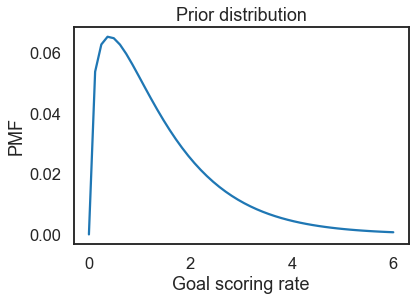

In [5]:
prior.plot()
decorate_rate('Prior distribution')

This prior implies:

1. The most common goal-scoring rates are near 1.

2. The goal-scoring rate is never 0; eventually, any team will score against any other.

3. The goal-scoring rate is unlikely to be greater than 4, and never greater than 6.

### The likelihood function

Suppose you are given the goal-scoring rate, $\lambda$, and asked to compute the probability of scoring a number of goals, $k$.  The answer is given by the Poisson PMF:

$ \mathrm{PMF}(k; \lambda) = \frac{\lambda^k \exp(-\lambda)}{k!} $

**Exercise 1:** Write a likelihood function that takes $k$ and $\lambda$ as parameters `data` and `hypo`, and computes $\mathrm{PMF}(k; \lambda)$.

You can use NumPy/SciPy functions or `scipy.stats.poisson`. 

In [6]:
def likelihood(data, hypo):
    """Likelihood function for World Cup
    
    data: integer number of goals in a game
    hypo: goal scoring rate in goals per game
    
    returns: float probability
    """
    # TODO: fill this in!
    return 1

In [7]:
# Solution

from math import factorial

def likelihood(data, hypo):
    """Likelihood function for World Cup
    
    data: integer number of goals in a game
    hypo: goal scoring rate in goals per game
    
    returns: float probability
    """
    k = data
    λ = hypo
    return λ**k * np.exp(-λ) / factorial(k)

In [8]:
# Solution

from scipy.stats import poisson

def likelihood(data, hypo):
    """Likelihood function for World Cup
    
    data: integer number of goals in a game
    hypo: goal scoring rate in goals per game
    
    returns: float probability
    """
    k = data
    λ = hypo
    return poisson.pmf(k, λ)

### Update

First we'll compute the posterior distribution for France, having seen them score 4 goals.

2.656282076744656

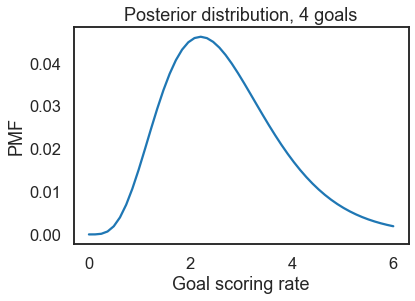

In [9]:
france = Pmf(prior, copy=True)

france.update(likelihood, 4)
france.plot(label='France')
decorate_rate('Posterior distribution, 4 goals')

france.mean()

**Exercise 2:** Do the same for Croatia.

1.695567117265963

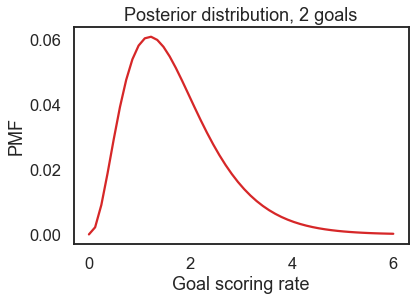

In [10]:
## Solution

croatia = Pmf(prior, copy=True)

croatia.update(likelihood, 2)
croatia.plot(label='Croatia', color='C3')
decorate_rate('Posterior distribution, 2 goals')

croatia.mean()

### Probability of superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the "probability of superiority", which is the probability that a random value drawn from France's disgrtibution exceeds a value drawn from Croatia's.

Remember that `Pmf` provides `choice`, which returns a random sample as a NumPy array:

In [11]:
sample_france = france.choice(size=1000)
sample_france.mean()

2.6122040816326524

**Exercise 3:** Generate a similar sample for Croatia; then compute the fraction of samples where the goal-scoring rate is higher for Croatia.  

Hint: use `np.mean`.

In [12]:
# Solution

sample_croatia = croatia.choice(size=1000)
sample_croatia.mean()

1.7168571428571426

In [13]:
# Solution

np.mean(sample_france > sample_croatia)

0.726

On the basis of one game, we have only moderate confidence that France is actually the better team.

### Predicting the rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?

To answer this question, we'll generate a sample from the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, $\lambda$, the distribution of goals would be $Poisson(\lambda)$.

Since we don't know $\lambda$, we can use the sample we generated in the previous section to generate a sample of goals, like this:

In [14]:
goals_france = np.random.poisson(sample_france)

Now we can plot the results:

In [15]:
def decorate_goals(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Goals scored')
    plt.ylabel('PMF')
    plt.ylim([0, 0.32])
    plt.title(title)

2.645

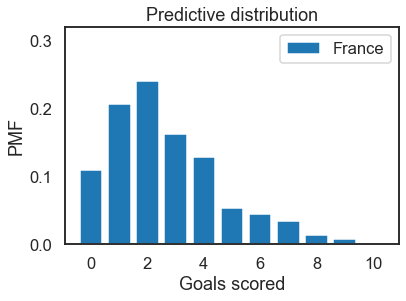

In [16]:
pmf_france = Pmf.from_seq(goals_france)
pmf_france.bar(label='France')
decorate_goals('Predictive distribution')
plt.legend()

goals_france.mean()

This distribution represents two sources of uncertainty: we don't know the actual value of $\lambda$, and even if we did, we would not know the number of goals in the next game.

**Exercise 4:** Generate and plot the predictive distribution for Croatia.

1.648

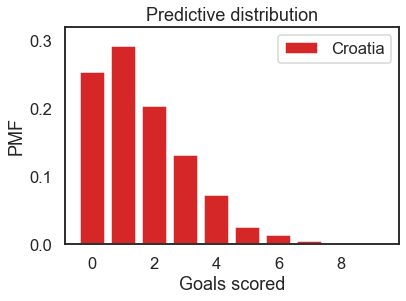

In [17]:
# Solution

goals_croatia = np.random.poisson(sample_croatia)

pmf_croatia = Pmf.from_seq(goals_croatia)
pmf_croatia.bar(label='Croatia', color='C3')
decorate_goals('Predictive distribution')
plt.legend()

goals_croatia.mean()

In a sense, these distributions represent the outcomes of 1000 simulated games.

**Exercise 5:** Compute the fraction of simulated rematches Croatia would win, how many France would win, and how many would end in a tie.

In [18]:
# Solution

np.mean(goals_croatia > goals_france)

0.253

In [19]:
# Solution

np.mean(goals_france > goals_croatia)

0.56

In [20]:
# Solution

np.mean(goals_france == goals_croatia)

0.187

Assuming that Croatia wins half of the ties, their chance of winning the rematch is about 33%.